#Detección de anomalias en Wafer Manufacturing

La detección de anomalías puede ser una tarea difícil y especialmente en el caso de conjuntos de datos etiquetados debido a cierto nivel de sesgo humano introducido al etiquetar el producto final como anómalo o bueno. Estos gigantescos sistemas de fabricación necesitan ser monitorizados cada 10 milisegundos para capturar su comportamiento, lo que aporta mucha información y lo que llamamos el IoT industrial (IIOT). Además, difícilmente un fabricante quiere crear un producto anómalo. Por lo tanto, las anomalías son como una aguja en un pajar que hace que el conjunto de datos sea significativamente desequilibrado.

Capturar un conjunto de datos de este tipo utilizando un modelo de aprendizaje automático y hacer que el modelo generalice puede ser divertido. En este dataset, se presenta un caso de uso de este tipo de uno de los principales fabricantes de obleas (semiconductores) de la India. El conjunto de datos recopilados fue anónimo para ocultar los nombres de las características, también hay 1558 características que requerirían algún conocimiento serio del dominio para entenderlas.

Sin embargo, en la era del aprendizaje profundo, estamos desafiando a la comunidad de la ciencia de los datos para llegar a un modelo de detección de anomalías que puede generalizar bien en el conjunto de datos no visto (datos de prueba). 

###Descripción del Dataset
- Train.csv - 1763 rows x 1559 columns
- Test.csv - 756 rows x 1558 columns

####Descripciónde atributos
- Feature1 - Feature1558 - Representa los atributos varios que fueron recopilados de la maquina de manufactura
- Class - (0 o 1) - Etiquetas de clase Representa Buena/Anómalo para los productos

#Preprocesamiento de datos

In [5]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from imblearn.over_sampling import RandomOverSampler
from scipy.cluster.vq import kmeans,vq
from scipy.cluster.hierarchy import fcluster,linkage
from scipy.stats.mstats import winsorize
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

### Unimos train y test para aplicar Feature Engineering
- Ya que test no tiene una columna objetivo

In [6]:
df=pd.read_csv('./Train.csv')
df_test=pd.read_csv('./Test.csv')
df_pred=pd.DataFrame()
df_both=pd.concat([df,df_test], ignore_index=True)
df_both

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100.0,160.0,1.6000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,20.0,83.0,4.1500,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
2,99.0,150.0,1.5151,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,40.0,40.0,1.0000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,12.0,234.0,19.5000,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2515,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2516,12.0,101.0,8.4166,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2517,31.0,88.0,2.8387,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


In [8]:
df.shape,df_test.shape,df_both.shape

((1763, 1559), (756, 1558), (2519, 1559))

In [9]:
df_both.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2519 entries, 0 to 2518
Columns: 1559 entries, feature_1 to Class
dtypes: float64(5), int64(1554)
memory usage: 30.0 MB


### Remuestreo de valores atípicos

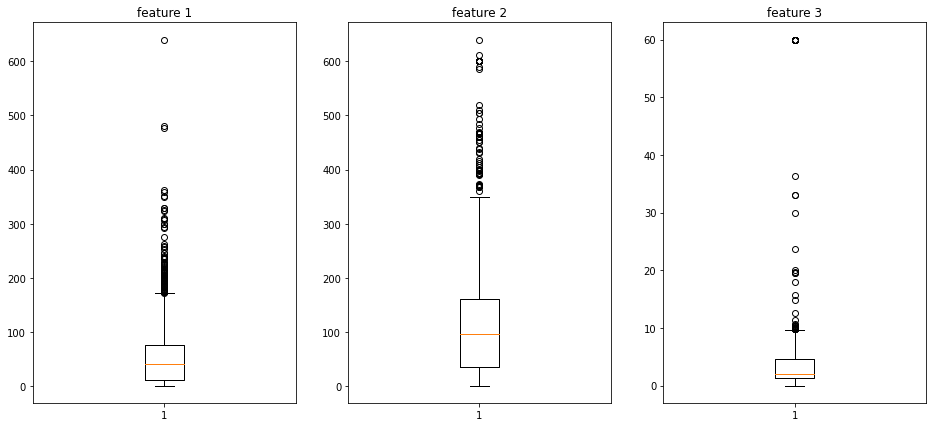

In [10]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(df_both[f'feature_{i+1}'])

In [11]:
for col in df_both.columns[:3]:
    l=0.1 if col=='feature_2' else 0.05
    df_both[col]=winsorize(df_both[col],limits=l)
df_both

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,100.0,160.0,1.6000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,20.0,83.0,4.1500,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
2,99.0,150.0,1.5151,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,40.0,40.0,1.0000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,12.0,234.0,8.4166,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2515,1.0,1.0,2.0000,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2516,12.0,101.0,8.4166,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2517,31.0,88.0,2.8387,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


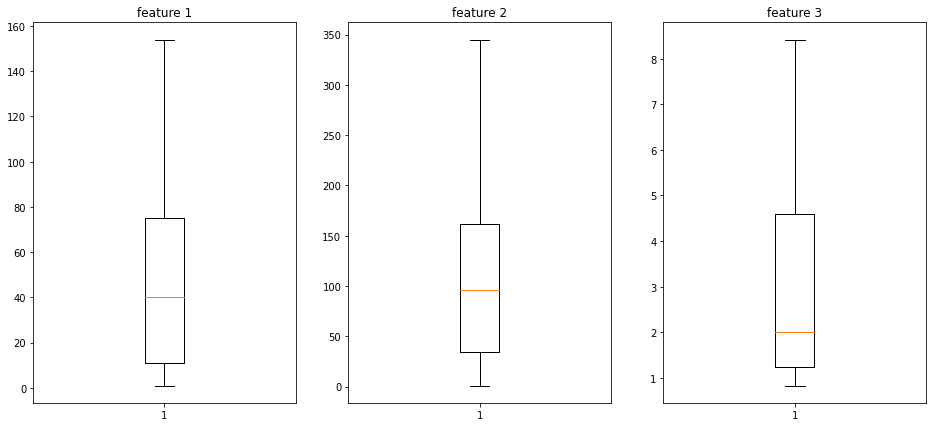

In [12]:
fig, axs =  plt.subplots(1,3,figsize = (16,7))
for i in range(3):
    axs[i].set_title(f'feature {i+1}')
    axs[i].boxplot(df_both[f'feature_{i+1}'])

### Escalado estandar de las 3 primeras features

In [13]:
df2=pd.DataFrame(StandardScaler().fit_transform(df_both.iloc[:,:3]),columns=df_both.columns[:3])
df_both=pd.concat([df2,df_both.iloc[:,3:]],axis=1)
df_both

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,1.073694,0.419477,-0.622123,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,-0.656580,-0.326405,0.388123,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
2,1.052066,0.322609,-0.655758,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,-0.224012,-0.742936,-0.859827,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,-0.829608,1.136298,2.078441,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2515,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2516,-0.829608,-0.152043,2.078441,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
2517,-0.418668,-0.277971,-0.131381,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN


### De nuevo separamos

In [14]:
df=df_both[:df.shape[0]]
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class
0,1.073694,0.419477,-0.622123,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1,-0.656580,-0.326405,0.388123,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0
2,1.052066,0.322609,-0.655758,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,-0.224012,-0.742936,-0.859827,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
4,-0.829608,1.136298,2.078441,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-1.067521,-1.120720,-0.463653,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1759,-0.224012,0.806948,0.724871,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1760,0.987180,0.981310,-0.356369,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
1761,-0.743094,-0.345778,0.749632,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [15]:
df_test=df_both[df.shape[0]+1:].iloc[:,:-1].reset_index(drop=True)
df_test

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1519,feature_1520,feature_1521,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558
0,1.246721,0.603526,-0.599382,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.208557,2.211530,1.834160,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.208557,0.032006,-0.463653,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.614405,0.080440,-0.859827,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
751,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
752,-0.829608,-0.152043,2.078441,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
753,-0.418668,-0.277971,-0.131381,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### OverSampling

In [17]:
def over_sample_train_test(x,y):
    ros=RandomOverSampler(random_state=0)
    ros.fit(x,y)
    x_res,y_res=ros.fit_resample(x,y)
    x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,test_size=0.2,random_state = 1)
    return x_train,x_test,y_train,y_test

x=df.drop('Class',axis=1)
y=df.Class
x_train,x_test,y_train,y_test=over_sample_train_test(x,y)

In [18]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2592, 1558), (648, 1558), (2592,), (648,))

### Aplicación de modelos de detección de anomalías

In [19]:
lr=LogisticRegression(solver='liblinear')    
svm=SVC(probability=True)
dt=DecisionTreeClassifier(max_depth=10,max_features=8,random_state=100)
rf=RandomForestClassifier(max_depth=4, max_features=3)
knn=KNeighborsClassifier(n_neighbors=94)
gnb=GaussianNB()
xgb=xgb=XGBClassifier(use_label_encoder=False,random_state=42,eval_metric='mlogloss')

In [20]:
def apply_model(model,x_train,x_test,y_train,y_test):
    print(' '*20+re.search(r'(.*)\(',f'''{model}''',re.M).group(1))
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    print('')
    print('Train Score:  ',model.score(x_train,y_train))
    print('Test Score:   ',model.score(x_test,y_test))
    print('')
    plot_confusion_matrix(model, x_test, y_test)
    print(classification_report(y_test,y_pred))

d={}
def predict_test(model):
    col=re.search(r'(.*)\(',f'''{model}''',re.M).group(1)
    if col not in d:
        d[col]=1
    else:
        d[col]+=1
    col+=f'{d[col]}'
    df_pred[col]=model.predict(df_test)
    df_pred

                    LogisticRegression

Train Score:   0.9564043209876543
Test Score:    0.9367283950617284



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       328
         1.0       0.93      0.95      0.94       320

    accuracy                           0.94       648
   macro avg       0.94      0.94      0.94       648
weighted avg       0.94      0.94      0.94       648



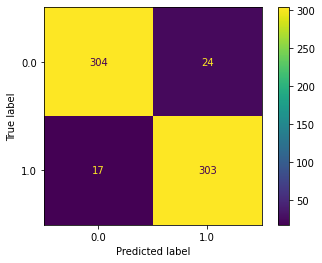

In [21]:
apply_model(lr,x_train,x_test,y_train,y_test)
predict_test(lr)

                    SVC

Train Score:   0.9567901234567902
Test Score:    0.9290123456790124



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93       328
         1.0       0.92      0.94      0.93       320

    accuracy                           0.93       648
   macro avg       0.93      0.93      0.93       648
weighted avg       0.93      0.93      0.93       648



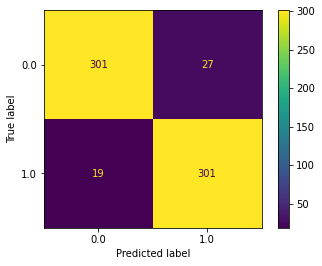

In [22]:
apply_model(svm,x_train,x_test,y_train,y_test)
predict_test(svm)

                    KNeighborsClassifier

Train Score:   0.8020833333333334
Test Score:    0.8148148148148148



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.76      0.92      0.83       328
         1.0       0.90      0.71      0.79       320

    accuracy                           0.81       648
   macro avg       0.83      0.81      0.81       648
weighted avg       0.83      0.81      0.81       648



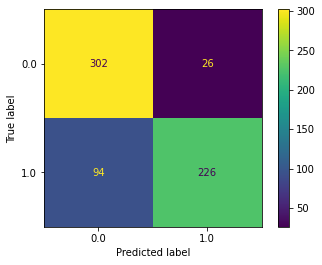

In [23]:
apply_model(knn,x_train,x_test,y_train,y_test)
predict_test(knn)

                    GaussianNB

Train Score:   0.8935185185185185
Test Score:    0.8950617283950617

              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88       328
         1.0       0.82      1.00      0.90       320

    accuracy                           0.90       648
   macro avg       0.91      0.90      0.89       648
weighted avg       0.91      0.90      0.89       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


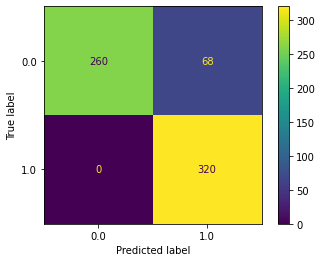

In [24]:
apply_model(gnb,x_train,x_test,y_train,y_test)
predict_test(gnb)

                    DecisionTreeClassifier

Train Score:   0.7735339506172839
Test Score:    0.7592592592592593

              precision    recall  f1-score   support

         0.0       0.69      0.94      0.80       328
         1.0       0.90      0.58      0.70       320

    accuracy                           0.76       648
   macro avg       0.80      0.76      0.75       648
weighted avg       0.80      0.76      0.75       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


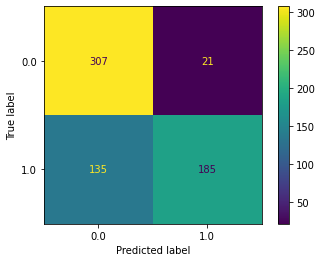

In [25]:
apply_model(dt,x_train,x_test,y_train,y_test) 
predict_test(dt)

                    RandomForestClassifier

Train Score:   0.8271604938271605
Test Score:    0.8070987654320988

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.83       328
         1.0       0.91      0.67      0.77       320

    accuracy                           0.81       648
   macro avg       0.83      0.81      0.80       648
weighted avg       0.83      0.81      0.80       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


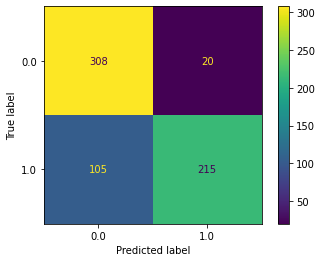

In [26]:
apply_model(rf,x_train,x_test,y_train,y_test) 
predict_test(rf)

                    XGBClassifier

Train Score:   0.9363425925925926
Test Score:    0.9120370370370371



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       328
         1.0       0.91      0.91      0.91       320

    accuracy                           0.91       648
   macro avg       0.91      0.91      0.91       648
weighted avg       0.91      0.91      0.91       648



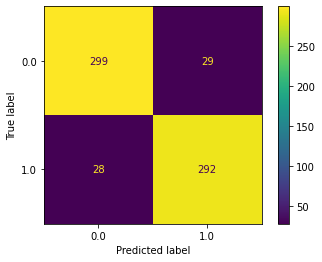

In [27]:
apply_model(xgb,x_train,x_test,y_train,y_test)
predict_test(xgb)

In [28]:
df_pred

,LogisticRegression1,SVC1,KNeighborsClassifier1,GaussianNB1,DecisionTreeClassifier1,RandomForestClassifier1,XGBClassifier1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### TSNE 

- solve again same sequence 

In [29]:
ts=TSNE(learning_rate=50)
features=ts.fit_transform(df_both.drop('Class',axis=1))
tsne_x,tsne_y='tsne_x','tsne_y'
df_both[tsne_x]=features[:,0]
df_both[tsne_y]=features[:,1]
df_both

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1522,feature_1523,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class,tsne_x,tsne_y
0,1.073694,0.419477,-0.622123,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-7.159538,-32.074173
1,-0.656580,-0.326405,0.388123,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,-44.190395,6.718396
2,1.052066,0.322609,-0.655758,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-27.415041,-30.843950
3,-0.224012,-0.742936,-0.859827,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.757212,7.614930
4,-0.829608,1.136298,2.078441,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-23.137554,18.454012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,1.728080,21.680328
2515,-1.067521,-1.120720,-0.463653,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,67.076530,-25.336819
2516,-0.829608,-0.152043,2.078441,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,21.436295,49.852020
2517,-0.418668,-0.277971,-0.131381,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,19.820862,21.046009


In [30]:
df=df_both[:df.shape[0]]
df_test=df_both[df.shape[0]+1:].iloc[:,-2:].reset_index(drop=True)
df_test

,tsne_x,tsne_y
0,38.548199,-25.271145
1,16.786253,26.740829
2,-33.554028,11.942518
3,-65.844650,1.084754
4,-9.468078,-20.000851
...,...,...
750,1.728080,21.680328
751,67.076530,-25.336819
752,21.436295,49.852020
753,19.820862,21.046009


In [31]:
x=df[[tsne_x,tsne_y]]
y=df[['Class']].values
x_train,x_test,y_train,y_test=over_sample_train_test(x,y)

                    LogisticRegression

Train Score:   0.7743055555555556
Test Score:    0.7839506172839507

              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78       328
         1.0       0.77      0.79      0.78       320

    accuracy                           0.78       648
   macro avg       0.78      0.78      0.78       648
weighted avg       0.78      0.78      0.78       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


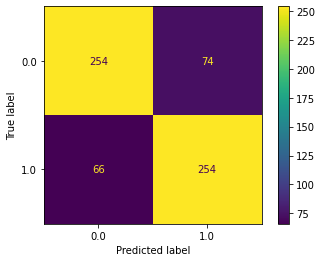

In [32]:
apply_model(lr,x_train,x_test,y_train,y_test)
predict_test(lr)

                    SVC

Train Score:   0.8198302469135802
Test Score:    0.8271604938271605

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       328
         1.0       0.85      0.79      0.82       320

    accuracy                           0.83       648
   macro avg       0.83      0.83      0.83       648
weighted avg       0.83      0.83      0.83       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


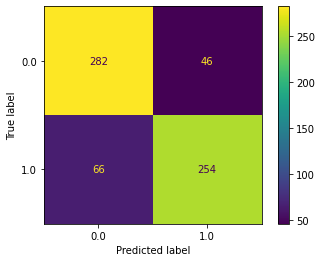

In [33]:
apply_model(svm,x_train,x_test,y_train,y_test)
predict_test(svm)

                    KNeighborsClassifier

Train Score:   0.816358024691358
Test Score:    0.8009259259259259



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80       328
         1.0       0.80      0.79      0.80       320

    accuracy                           0.80       648
   macro avg       0.80      0.80      0.80       648
weighted avg       0.80      0.80      0.80       648



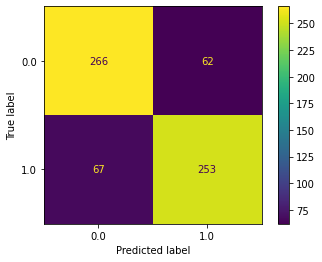

In [34]:
apply_model(knn,x_train,x_test,y_train,y_test)
predict_test(knn)

                    GaussianNB

Train Score:   0.7712191358024691
Test Score:    0.7746913580246914

              precision    recall  f1-score   support

         0.0       0.78      0.77      0.77       328
         1.0       0.77      0.78      0.77       320

    accuracy                           0.77       648
   macro avg       0.77      0.77      0.77       648
weighted avg       0.77      0.77      0.77       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


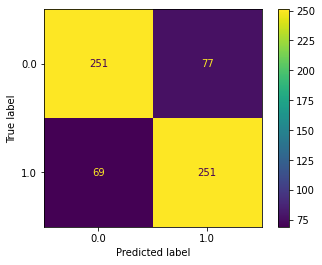

In [35]:
apply_model(gnb,x_train,x_test,y_train,y_test) 
predict_test(gnb)

                    XGBClassifier

Train Score:   0.9197530864197531
Test Score:    0.904320987654321

              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90       328
         1.0       0.88      0.93      0.91       320

    accuracy                           0.90       648
   macro avg       0.91      0.90      0.90       648
weighted avg       0.91      0.90      0.90       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


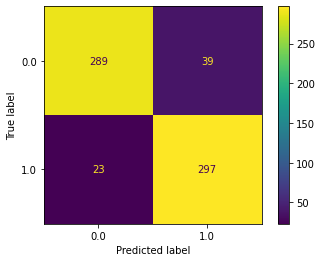

In [36]:
apply_model(xgb,x_train,x_test,y_train,y_test)
predict_test(xgb)

In [37]:
def kmeans_clus(df,not_x,not_y,k,cluster_label):
    df=df.copy()
    centroids,distortions=kmeans(df[[not_x,not_y]],k_or_guess=k)
    labels,_=vq(df[[not_x,not_y]],centroids)
    df[cluster_label]=labels
    sns.scatterplot(x=not_x,y=not_y,data=df,hue=cluster_label)
    for i in range(k):
        plt.scatter(x=centroids[i,0],y=centroids[i,1],s=500,cmap='Cyan')

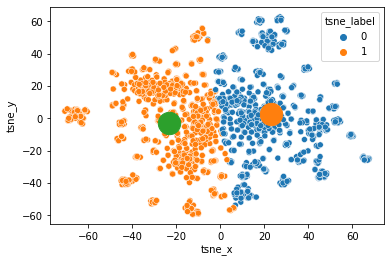

In [38]:
kmeans_clus(df,tsne_x,tsne_y,2,'tsne_label')

### Análisis de componentes principales

El análisis de componentes principales es una tecnica que es usada para reducir la dimensionalidad del Dataset. Se utiliza para reducir el número de columnas en el dataset.

In [39]:
pca=PCA(random_state=44)
pc=pca.fit_transform(df_both.drop('Class',axis=1))
len(pc[0])
pc_x,pc_y='pc_x','pc_y'
df_both[pc_x]=pc[:,0]
df_both[pc_y]=pc[:,1]

In [40]:
df=df_both[:df.shape[0]]
df_test=df_both[df.shape[0]+1:].iloc[:,-2:].reset_index(drop=True)

In [41]:
x=df[[pc_x,pc_y]]
y=df[['Class']].values
x_train,x_test,y_train,y_test=over_sample_train_test(x,y)

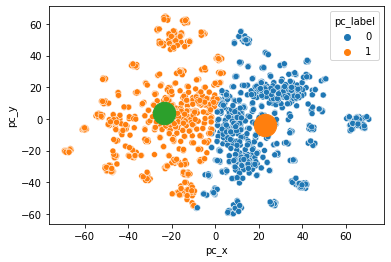

In [42]:
kmeans_clus(df,pc_x,pc_y,2,'pc_label')

                    LogisticRegression

Train Score:   0.7743055555555556
Test Score:    0.7839506172839507

              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78       328
         1.0       0.77      0.79      0.78       320

    accuracy                           0.78       648
   macro avg       0.78      0.78      0.78       648
weighted avg       0.78      0.78      0.78       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


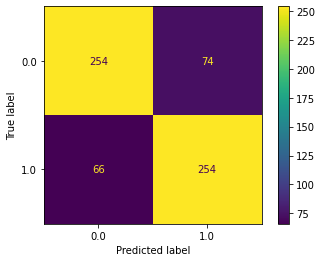

In [43]:
apply_model(lr,x_train,x_test,y_train,y_test)
predict_test(lr)

                    SVC

Train Score:   0.8206018518518519
Test Score:    0.8271604938271605

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       328
         1.0       0.85      0.79      0.82       320

    accuracy                           0.83       648
   macro avg       0.83      0.83      0.83       648
weighted avg       0.83      0.83      0.83       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


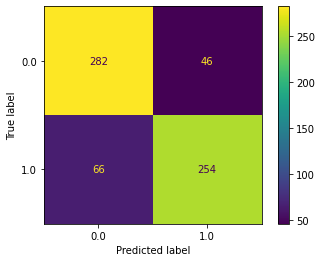

In [44]:
apply_model(svm,x_train,x_test,y_train,y_test)
predict_test(svm)

                    KNeighborsClassifier

Train Score:   0.8167438271604939
Test Score:    0.8009259259259259

              precision    recall  f1-score   support

         0.0       0.80      0.81      0.80       328
         1.0       0.80      0.79      0.80       320

    accuracy                           0.80       648
   macro avg       0.80      0.80      0.80       648
weighted avg       0.80      0.80      0.80       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


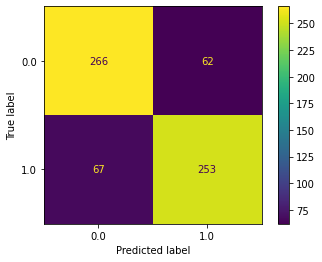

In [45]:
apply_model(knn,x_train,x_test,y_train,y_test)
predict_test(knn)

                    GaussianNB

Train Score:   0.7716049382716049
Test Score:    0.7700617283950617

              precision    recall  f1-score   support

         0.0       0.78      0.76      0.77       328
         1.0       0.76      0.78      0.77       320

    accuracy                           0.77       648
   macro avg       0.77      0.77      0.77       648
weighted avg       0.77      0.77      0.77       648



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


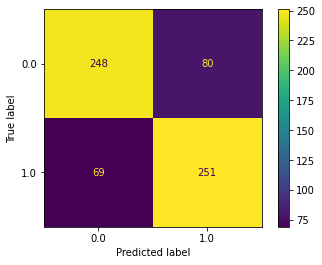

In [46]:
apply_model(gnb,x_train,x_test,y_train,y_test) 
predict_test(gnb)

                    XGBClassifier

Train Score:   0.9293981481481481
Test Score:    0.904320987654321



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         0.0       0.93      0.88      0.90       328
         1.0       0.88      0.93      0.91       320

    accuracy                           0.90       648
   macro avg       0.91      0.90      0.90       648
weighted avg       0.91      0.90      0.90       648



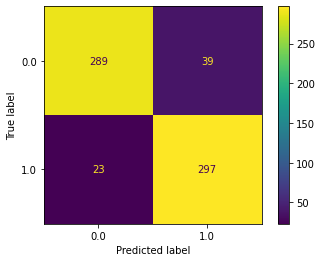

In [47]:
apply_model(xgb,x_train,x_test,y_train,y_test)
predict_test(xgb)

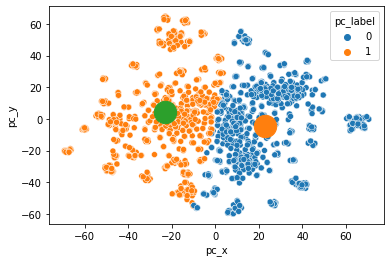

In [48]:
kmeans_clus(df,pc_x,pc_y,2,'pc_label')

### Predicciones finales para test

In [49]:
df_pred

,LogisticRegression1,SVC1,KNeighborsClassifier1,GaussianNB1,DecisionTreeClassifier1,RandomForestClassifier1,XGBClassifier1,LogisticRegression2,SVC2,KNeighborsClassifier2,GaussianNB2,XGBClassifier2,LogisticRegression3,SVC3,KNeighborsClassifier3,GaussianNB3,XGBClassifier3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
df

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,...,feature_1524,feature_1525,feature_1526,feature_1527,feature_1528,feature_1529,feature_1530,feature_1531,feature_1532,feature_1533,feature_1534,feature_1535,feature_1536,feature_1537,feature_1538,feature_1539,feature_1540,feature_1541,feature_1542,feature_1543,feature_1544,feature_1545,feature_1546,feature_1547,feature_1548,feature_1549,feature_1550,feature_1551,feature_1552,feature_1553,feature_1554,feature_1555,feature_1556,feature_1557,feature_1558,Class,tsne_x,tsne_y,pc_x,pc_y
0,1.073694,0.419477,-0.622123,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-7.159538,-32.074173,4.727588,-32.375670
1,-0.656580,-0.326405,0.388123,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,-44.190395,6.718396,44.275695,3.869625
2,1.052066,0.322609,-0.655758,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-27.415041,-30.843950,25.003875,-32.518195
3,-0.224012,-0.742936,-0.859827,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.757212,7.614930,-0.512342,7.764311
4,-0.829608,1.136298,2.078441,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-23.137554,18.454012,24.121317,17.028977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,-1.067521,-1.120720,-0.463653,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,13.525126,19.311239,-12.461208,20.325172
1759,-0.224012,0.806948,0.724871,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-33.733597,-12.734580,32.549504,-14.830981
1760,0.987180,0.981310,-0.356369,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,-16.024607,-15.496296,14.709866,-16.435610
1761,-0.743094,-0.345778,0.749632,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.895419,37.878639,1.432547,38.002115
